# Evaluating problem of predicting Lending Club loan outcomes

In [1]:
%load_ext lab_black
%load_ext autoreload
%autoreload 2

In [2]:
from multiprocessing import cpu_count

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import pandas as pd
import seaborn as sns
from joblib import Parallel, delayed
from sklearn.dummy import DummyClassifier

In [3]:
%aimport src.business_helpers
from src.business_helpers import convert_confusion_matrix_to_business_cost

%aimport src.visualization_helpers
from src.visualization_helpers import plot_multiple_boxplots, plot_multi_catplot

## About

This will be a scoping exercise to explore the outcome of Lending Club loans. The total income (total return) that an investor can expect to gain/lose by simple techniques to predict all loan outcomes will be estimated using artifically generated data. This will inform the stakeholder (a conservative investor) as to whether more advanced techniques to predict these outcomes are warranted. Quantitative performance per loan for the naively made predictions will also be established as a baseline against which more advanced techniques can be compared.

## User Inputs

In [4]:
np.random.seed(2)

In [5]:
frac_defaults = 0.15
n_rows = 10_000
P_mean = 11_000
P_std = 5_000
A_mean = 0.15
class_labels = [0, 1]

In [10]:
class Borrowers:
    def __init__(self, frac_defaults=0.10, n_samples=10_000, classes=[0, 1]):
        self.frac_defaults = frac_defaults
        self.n_samples = n_samples
        self.classes = classes

    def get_random_samples(self):
        probabilities = [(1 - self.frac_defaults), self.frac_defaults]
        return np.random.choice(self.classes, self.n_samples, p=probabilities)

In [6]:
def generate_predictions(df, strategy="uniform", frac_defaults=0.15):
    if strategy != "random":
        clf = DummyClassifier(strategy=strategy)
        clf.fit(df[["t"]], df["t"])
        p = pd.Series(clf.predict(df[["t"]]), index=df.index)
    else:
        p = pd.Series(0, index=df.index)
        p.iloc[p.sample(frac=frac_defaults, random_state=55).index] = 1
    return p

In [7]:
def rowwise_calculate_avg_return_vs_theoretical(
    principal,
    y_true,
    y_pred,
    total_income,
):
    cm_labels = np.sort(np.unique([0, 1]))
    ds_predicted = convert_confusion_matrix_to_business_cost(
        y_true,
        y_pred,
        cm_labels,
        principal,
        total_income,
    )
    ds_true = convert_confusion_matrix_to_business_cost(
        y_true,
        y_true,
        cm_labels,
        principal,
        total_income,
    )
    err = np.abs(ds_predicted - ds_true)
    return err

In [8]:
def calculate_return(P, A, df):
    s = pd.Series(
        np.zeros(
            [
                len(df),
            ]
        ),
        index=df.index,
    )

    # Following manual approach could also be done using a
    # confusion matrix
    indx = df.loc[(df["t"] == 1) & (df["p"] == 0)].index
    s.loc[indx] = -P

    indx = df.loc[(df["t"] == 0) & (df["p"] == 1)].index
    s.loc[indx] = -A

    indx = df.loc[(df["t"] == 1) & (df["p"] == 1)].index
    s.loc[indx] = 0

    indx = df.loc[(df["t"] == 0) & (df["p"] == 0)].index
    s.loc[indx] = A
    return s

In [9]:
def calculate_ae_return(df, strategy="most_frequent", frac_defaults=0.15, trial_num=1):
    df["p"] = generate_predictions(df, strategy, frac_defaults)
    return {
        f"ae": pd.Series(
            np.vectorize(rowwise_calculate_avg_return_vs_theoretical)(
                df["P"],
                df["t"],
                df["p"],
                df["A"],
            ),
            index=df.index,
        ).tolist(),
        f"return": calculate_return(df["P"], df["A"], df),
        "strategy": [strategy] * len(df),
        "trial": [trial_num] * len(df),
    }

In [ ]:
def run_single_trial(df, frac_defaults, n=1):
    executor = Parallel(n_jobs=cpu_count(), backend="multiprocessing")
    tasks = (
        delayed(calculate_ae_return)(df, s, frac_defaults, n)
        for s in ["uniform", "stratified", "most_frequent", "random"]
    )
    dict_scores = executor(tasks)
    dfs = [
        (pd.DataFrame(dict_score.values()).T).rename(
            columns={
                0: list(dict_score.keys())[0],
                1: list(dict_score.keys())[1],
                2: "strategy",
                3: "trial",
            }
        )
        for dict_score in dict_scores
    ]
    dfs_ae_scores = pd.concat(dfs)
    dfs_ae_scores[["ae", "return"]] = dfs_ae_scores[["ae", "return"]].apply(
        pd.to_numeric, errors="coerce"
    )
    return dfs_ae_scores

## Generate Data

### Generate true outcomes randomly

The following is the reasoning used in simulating the data to represent the outcomes of the loans - the `t` column below
1. When the borrower defaults on a loan, this outcome is a deterministic process. It does not occur randomly. If the internal state of the borrower is known, it is possible to assign whether or not the loan will result in a default. There is no randomness in this assignment process itself. All the randomness is only assumed to determine the outcome since it is not known *apriori* how the internal state of the borrower works.
2. Although not done here, borrowers themselves could generated at random. Everything about them is not known at this time. There are a lot of details (internal state) about the loan borrower and we are completely unaware of what those are when they borrow the loan. This determines the loan outcome. But the loan borrowers could be sampled from a population of people. Their preferences woluld be fixed when they are created. We would not know what they are but they would be set when they are created. We decide whether they default or not. In the current case, the loan borrowers aren't created but their outcomes are randomly assigned.

In [11]:
df = pd.DataFrame(
    Borrowers(frac_defaults, n_rows, class_labels).get_random_samples(),
    index=range(n_rows),
    columns=["t"],
)
display(df["t"].value_counts(normalize=True).to_frame())

,t
0,0.8505
1,0.1495


In [ ]:
# df = pd.DataFrame(np.zeros([n_rows, 1]), index=range(n_rows), columns=["t"]).astype(int)
# df.iloc[df["t"].sample(frac=frac_defaults, random_state=6).index, 0] = 1
# display(df["t"].value_counts(normalize=True).to_frame())

### Generate randomly distributed loan amounts (principals)

Next, the loan principal (a continuous variable) is assumed to follow a normal distribution with an average value of $\$$11,000. The standard deviation of the distribution is chosen to be $\$$5,000. Negative and zero values are filtered out of the data, since the loan principal cannot be negative. The maximum loan generated using this approach is approximately $\$$30,000.

In [12]:
df["P"] = np.random.normal(P_mean, P_std, size=len(df))
df = df.loc[df["P"] > 0].reset_index(drop=True)

### Approximate loan income (return) as fraction of principal

The total loan return is assumed to be 15% of the principal, which is approximately the highest possible return [reported in Lending Club's historical data](https://www.lendingclub.com/info/demand-and-credit-profile.action) (see chart titled **NET ANNUALIZED RETURN BY VINTAGE**). Note that in this chart, the annualized return is re-calculated after each month of the term of the loan.

From the chart in the historical data, the reported anualized return starts at approx. 15% and then drops off over the term of the loan (shown in the historical data by month). For a 36 month (three year) term, the annualized return of 15% should be expected to have been received by the lender for each of the three years. The simplifying assumption made here is that the annual return stays constant at 15% and represents an over-estimation of the true return.

In [13]:
df["A"] = df["P"] * A_mean

The first ten rows of the data are shown below

In [14]:
df.head(10)

,t,P,A
0,0,11519.126527,1727.868979
1,0,11534.550549,1730.182582
2,0,7486.099640,1122.914946
3,0,8848.873913,1327.331087
4,0,5625.740410,843.861061
5,0,17880.662221,2682.099333
6,0,10754.157881,1613.123682
7,0,23305.174523,3495.776178
8,0,6625.814067,993.872110
9,0,12148.365773,1822.254866


The number of observations after dropping negative simulated loan principals is shown below

In [15]:
df.shape[0]

9853

## Make Predictions Using Various Randomization Strategies

Several strategies will now be used to generate naive predictions of the loan outcome of each artificially generated loan. This will give the following
- baseline prediction error per loan that more sophisticated analytical approaches should achieve in order to be considered useful
  - note that since this error is only computed on artificially generated data, with assumptions made about principal (averge of $\$$15,000) and loan income, this error represents an approximation and needs to be re-calculated using real data
- total possible loan income (total return) that an investor (loan lender) can expect to receive/lose if they relied on the naive predictions
  - depending on the investor's finances and assuming that this total income is a loss
    - if the investor can absorb these possible losses, then one of these naive approaches to randomly assigning loan outcomes could be sufficient for instructing them as to whether or not they should fund all the loans on Lending Club
    - if these losses are too large to be absorbed, then this would be justification for proceeding to a more sophisticated analysis technique such as machine learning to predict the outcome of the loans

The error is calculated by assigning a cost (penalizing or rewarding) the predictions made of loan outcomes, depending on how they compare to the true outcomes. The costs (or loan incomes) are
- actual outcome is loan defaulted and predicted outcome is loan paid off on time
  - in this scenario, the investor followed the predicted outcome and made an investment so the full principal is lost and the net income is -P
  - return was not there to be made, following the naive prediction, so return was not lost
- actual outcome is loan defaulted and predicted outcome is loan defaulted
  - no investment was made, pre the prediction of default
  - return was not there to be made, following the naive prediction, so the return was not lost
  - net income is $\$$0
- actual outcome is loan was paid off on time and predicted outcome is loan paid off on time
  - investment was made, since the prediction was that the loan will be paid off on time
  - return was there to be made and was made
  - net income is A
- actual outcome is loan was paid off on time and predicted outcome is loan goes into default
  - investment was not made, since the prediction was that the loan will end in a default
  - return was there to be made but was not made
  - net income is -A

One of these four types of net incomes or losses (-P, $\$$0, A or -A) is assigned for each loan. This will be the income (earned or lost) per loan.

In [16]:
%%time
executor = Parallel(n_jobs=cpu_count(), backend='multiprocessing')
tasks = (delayed(calculate_ae_return)(df, s, frac_defaults) for s in ["uniform", "stratified", "most_frequent", "random"])
dict_scores = executor(tasks)
dfs = [
    (pd.DataFrame(dict_score.values()).T).rename(columns={0: list(dict_score.keys())[0], 1: list(dict_score.keys())[1], 2: "strategy"})
    for dict_score in dict_scores
]
dfs_ae_scores = pd.concat(dfs)
dfs_ae_scores[["ae", "return"]] = dfs_ae_scores[["ae", "return"]].apply(
    pd.to_numeric, errors="coerce"
)

CPU times: user 1.61 s, sys: 67.3 ms, total: 1.68 s
Wall time: 9.77 s


A helper function is available to run all of the above steps in a single line (this is not done here)
```
dfs_ae_scores = pd.concat([run_single_trial(df, frac_defaults, 1)])
display(dfs_ae_scores)
```

## (Randomized) Evaluation of naive predictions

A simple evaluation of the naive predictions is shown here.

### Comparison of Prediction Error and Return per loan

First, all the errors (absolute values) and loan income (return), attributed to naively predicting a single loan outcome are shown below

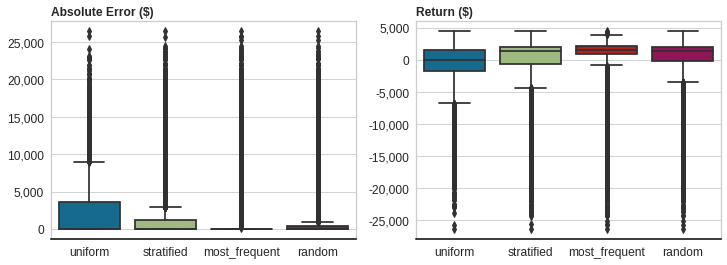

In [17]:
plot_multiple_boxplots(
    dfs_ae_scores,
    x="strategy",
    y_s=["ae", "return"],
    ptitles=["Absolute Error ($)", "Return ($)"],
    axis_tick_label_fontsize=12,
    x_ticks_formatter="{x:,.0f}",
    fig_size=(12, 4),
)

**Notes**
1. All artifically generated loan outcomes are represented on these charts.
2. Per its definition here, the error is an absolute value and so has a minimum of zero. In the cases where naively guessing at the loan outcome was correct, the error could be zero.
3. The return is not an absolute value and so it could positive or negative. The absolute value of the return is the absolute error in the naive prediction so the minimum return per loan is the same as the absolute value of the error and this is seen from the two plots.

**Observations**
1. Per loan, the investor could expect to lose as much as approx. $\$$25,000 for any of the naive prediction strategies used.
2. The best approach to minimizing error or maximizing return per loan is to assume that every loan will be paid off. While losses remain a possibility, this strategy (`most_frequent`) produces the lowest median absolute error and highest median return per loan.

### Mean Absolute Error and Total Loan Return

Next, an aggregated version of the above plots is shown. The average of the absolute error per loan (MAE) and the total return over all the simulated loans are calculated

In [18]:
grouped = dfs_ae_scores.groupby(["strategy"]).agg({"ae": ["mean"], "return": ["sum"]})
grouped.columns = grouped.columns.map("|".join)
grouped = grouped.unstack().reset_index()
grouped = grouped.rename(columns={"level_0": "var", 0: "value"})
display(grouped)

,var,strategy,value
0,ae|mean,most_frequent,1.683048e+03
1,ae|mean,random,1.831472e+03
2,ae|mean,stratified,1.860601e+03
3,ae|mean,uniform,2.234586e+03
4,return|sum,most_frequent,-2.371881e+06
5,return|sum,random,-3.834301e+06
6,return|sum,stratified,-4.121309e+06
7,return|sum,uniform,-7.806188e+06


In [ ]:
plot_multi_catplot(
    grouped,
    x="strategy",
    y="value",
    cat_columns="var",
    ptitles=["MAE ($)", "Return ($)"],
    axis_tick_label_fontsize=12,
    x_ticks_formatter="{x:,.0f}",
    plot_color="red",
    fig_height=4,
    fig_aspect_ratio=1.25,
)

**Observations**
1. As expected, the strategy of guessing that every loan will be paid off on time maximizes the totla return and minimizes the MAE. Since the total return is computed by adding up the returns of all the inidivual loans, summing the negative returns results in the total returns being negative. This suggests that approximately $\$$2,000,000 could be lost by adopting this approach. Higher losses would be incurred using other naive prediction techniques.
2. The more defaults that occur the worse the best-case strategy for losses could be. Lost principal is the biggest contributor to lost loan income (lost loan return). This penalty is attributed to loans that result in a default (true outcome) but that are predicted to be paid off on time. Using the best naive strategy here involves guessing that all loans will be paid off on time. As the number of defaults in the data (here, assumed to be 15\% of all loans) increases, this penalty (lost principal) is applied with greater frequency and will increase the overall lost income. Future work may seek to inform the investor as to higher lossess that could be incurred if this nominal value of 15\% is an underestimate of the true fraction of defaults expected.

## Looking Forward

Additional iterations of the scoping exercise here could include the following investigations and many be instructive in providing guidane to the client (investor)
- different distributions, and their parameters (average, etc.), to model the loan principal
  - here a normal distribution was assumed with an average of $\$$2,000,000
- additional naive prediction strategies
  - four strategies were used here to generate predictions of loan outcome
- vary the technique used to generate true loan outcomes, without introducing lookahead bias
  - here, these were randomly sampled
- trying different values for the annual return
  - this was assumed to be 15\% here
- vary the class imbalane between loans paid off on time and those that went into default
  - here, it was assumed that 85\% of loans were paid off on time, while 15\% went into default
  - a higher fraction of defaults in the data will increase the losses incurred by an investor looking to fund these loans

## Conclusion

Since the intended business use-case is targeted to a conservative investor, they should prefer to minimize negative returns from any approach to predicting the outcome of loans. Using a naive strategy of assuming that every loan will be paid off on time results in approximately $\$$2,000,000 in losses. It is reasonable to assume that a conservative investor would want to cut this down as much as possible. In this case, it is worthwhile to pursue more advanced quantitative analytical techniques, to generate predictions of loan outcome, such as machine learning (ML) where a preliminary MAE of approximately $\$$2,000 should serve as the baseline for assessing ML model performance. This is assumed to be the case here and so data acquisition from Lending Club and ML model development will be proceed.